In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.9'
os.environ['OMP_NUM_THREADS']='1'
os.environ['XLA_FLAGS'] = (
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
)
#os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
#os.environ['XLA_FLAGS']='--xla_gpu_deterministic_reductions --xla_gpu_autotune_level=1'

os.environ.update({
  "NCCL_LL128_BUFFSIZE": "-2",
  "NCCL_LL_BUFFSIZE": "-2",
   "NCCL_PROTO": "SIMPLE,LL,LL128",
 })

import sys
sys.path.append('../')

from models import scalar
import pickle
import time
from typing import Callable, Sequence

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
#import sympy
#import optuna
from util import *
from itertools import product
from functools import partial


import matplotlib
import matplotlib.pyplot as plt
import scipy.special as special

matplotlib.style.use('default') # 'classic'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.prop_cycle'] = plt.cycler(color='krbg')
matplotlib.rcParams['legend.numpoints'] = 1

%load_ext autoreload
%autoreload 2

@jax.jit
def arcsinh(x: any) -> any:
    return jnp.arcsinh(x)


@jax.jit
def sinh(x: any) -> any:
    return jnp.sinh(x)

jax.config.update("jax_default_matmul_precision", "highest")
# jax.config.update("jax_enable_x64", True)

# jax.config.update("jax_platform_name","cpu")
num_devices = jax.local_device_count()
jax.devices()

# jax.config.values

[CudaDevice(id=0)]

In [2]:
class MLP(nn.Module):
    volume: int
    features: Sequence[int]
    kernel_init: Callable = nn.initializers.variance_scaling(
        2, "fan_in", "truncated_normal")  # for ReLU / CELU
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.Dense(feat, use_bias=False,
                         kernel_init=self.kernel_init,
                         bias_init=self.bias_init)(x)
            x = arcsinh(x)
        x = nn.Dense(1, use_bias=False,
                     kernel_init=self.bias_init)(x)
        return x


class CV_MLP(nn.Module):
    volume: int
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = MLP(self.volume, self.features)(x)
        y = self.param('bias', nn.initializers.zeros, (1,))
        return x, y


# 8x8x8x8

jack bin size 1: (np.float32(0.0012261154), np.complex128(8.457335901062821e-06+0j))
bin size 1: (np.float32(0.0012261154), np.complex128(8.457215177327146e-06+0j))
jack bin size 2: (np.float32(0.0012261154), np.complex128(1.188898502447743e-05+0j))
bin size 2: (np.float32(0.0012261154), np.complex128(1.188875654250737e-05+0j))
jack bin size 4: (np.float32(0.0012261154), np.complex128(1.6674702039371887e-05+0j))
bin size 4: (np.float32(0.0012261154), np.complex128(1.6674478345081373e-05+0j))
jack bin size 5: (np.float32(0.0012261154), np.complex128(1.8570313994637877e-05+0j))
bin size 5: (np.float32(0.0012261154), np.complex128(1.8570103940859812e-05+0j))
jack bin size 10: (np.float32(0.0012261154), np.complex128(2.5810362289028454e-05+0j))
bin size 10: (np.float32(0.0012261154), np.complex128(2.5810409076912232e-05+0j))
jack bin size 20: (np.float32(0.0012261154), np.complex128(3.539596039395593e-05+0j))
bin size 20: (np.float32(0.0012261154), np.complex128(3.5395973855591765e-05+0j))

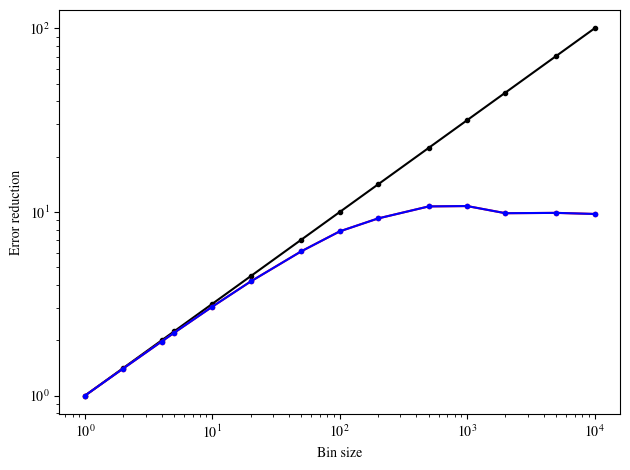

In [3]:
with open("scalar4d/config/c_8x8x8x8_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(8,8,8,8), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, 4))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [13]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])




def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

dS = jax.grad(lambda y: model.action(y).real)

@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [10]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 8.053002602537163e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.0001977291249204427 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0013349775), np.complex128(0.0004457945290465556+0j)) <f>: (np.float32(-0.00014708974), np.complex128(0.0004315429078250267+0j))
Epoch 200: <Test loss>: 1.5367608057204052e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0012696672), np.complex128(3.786906336899122e-05+0j)) <f>: (np.float32(-8.177896e-05), np.complex128(7.870202774169537e-05+0j))
Epoch 300: <Test loss>: 2.450232443607092e-07 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0012460483), np.complex128(1.726140217430207e-05+0j)) <f>: (np.float32(-5.815997e-05), n

In [12]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 8.053002602537163e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 1.1525461331984843e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.00128225), np.complex128(3.109199071890805e-05+0j)) <f>: (np.float32(-9.436116e-05), np.complex128(7.198642106155998e-05+0j))
Epoch 400: <Test loss>: 8.321566724589502e-07 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0012537589), np.complex128(2.8575503461937545e-05+0j)) <f>: (np.float32(-6.58708e-05), np.complex128(7.597172477811295e-05+0j))
Epoch 600: <Test loss>: 5.552923880713934e-07 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0012380121), np.complex128(2.203113884519633e-05+0j)) <f>: (np.float32(-5.012356e-05), np.c

In [14]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 8.053002602537163e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 5.477861577674048e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0012652889), np.complex128(7.829892007900187e-05+0j)) <f>: (np.float32(-7.739968e-05), np.complex128(0.00011691616795212846+0j))
Epoch 800: <Test loss>: 1.7835769767771126e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.001247098), np.complex128(4.8570187843036296e-05+0j)) <f>: (np.float32(-5.9209928e-05), np.complex128(8.126070409552061e-05+0j))
Epoch 1200: <Test loss>: 1.172783640868147e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.001234179), np.complex128(3.6023038642482217e-05+0j)) <f>: (np.float32(-4.6291592e-05)

In [16]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 8.053002602537163e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 9.261979357688688e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0012220592), np.complex128(8.877955280442195e-05+0j)) <f>: (np.float32(-3.4172383e-05), np.complex128(9.280778299539169e-05+0j))
Epoch 1600: <Test loss>: 1.4695173376821913e-05 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0009915578), np.complex128(0.00010695480760618799+0j)) <f>: (np.float32(0.0001963303), np.complex128(8.663077115837713e-05+0j))
Epoch 2400: <Test loss>: 6.63722539684386e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0012030159), np.complex128(7.502183183120655e-05+0j)) <f>: (np.float32(-1.5128101e-05),

In [18]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 1800:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 8.053002602537163e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 2.1847345124115236e-05 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011276483), np.complex128(0.00013344691221477728+0j)) <f>: (np.float32(6.0240276e-05), np.complex128(0.00012199213237081415+0j))
Epoch 3200: <Test loss>: 9.977076842915267e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0010025416), np.complex128(7.56549933644583e-05+0j)) <f>: (np.float32(0.00018534606), np.complex128(8.04212829934699e-05+0j))
Epoch 4800: <Test loss>: 1.2470858564483933e-05 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011014277), np.complex128(0.00011633308466276595+0j)) <f>: (np.float32(8.6460335e-05

## 2 hours run

In [6]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])




def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)

dS = jax.grad(lambda y: model.action(y).real)

@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [5]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 7200:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 8.053002602537163e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.0001977291249204427 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0013349775), np.complex128(0.0004457945290465556+0j)) <f>: (np.float32(-0.00014708974), np.complex128(0.0004315429078250267+0j))
Epoch 200: <Test loss>: 1.5367608057204052e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0012696672), np.complex128(3.786906336899122e-05+0j)) <f>: (np.float32(-8.177896e-05), np.complex128(7.870202774169537e-05+0j))
Epoch 300: <Test loss>: 2.450232443607092e-07 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0012460483), np.complex128(1.726140217430207e-05+0j)) <f>: (np.float32(-5.815997e-05), n

In [7]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 7200:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 8.053002602537163e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 1.1525461331984843e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.00128225), np.complex128(3.109199071890805e-05+0j)) <f>: (np.float32(-9.436116e-05), np.complex128(7.198642106155998e-05+0j))
Epoch 400: <Test loss>: 8.321566724589502e-07 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0012537589), np.complex128(2.8575503461937545e-05+0j)) <f>: (np.float32(-6.58708e-05), np.complex128(7.597172477811295e-05+0j))
Epoch 600: <Test loss>: 5.552923880713934e-07 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0012380121), np.complex128(2.203113884519633e-05+0j)) <f>: (np.float32(-5.012356e-05), np.c

In [9]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 7200:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 8.053002602537163e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 5.477861577674048e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0012652889), np.complex128(7.829892007900187e-05+0j)) <f>: (np.float32(-7.739968e-05), np.complex128(0.00011691616795212846+0j))
Epoch 800: <Test loss>: 1.7835769767771126e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.001247098), np.complex128(4.8570187843036296e-05+0j)) <f>: (np.float32(-5.9209928e-05), np.complex128(8.126070409552061e-05+0j))
Epoch 1200: <Test loss>: 1.172783640868147e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.001234179), np.complex128(3.6023038642482217e-05+0j)) <f>: (np.float32(-4.6291592e-05)

In [11]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 7200:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 8.053002602537163e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 9.261979357688688e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0012220592), np.complex128(8.877955280442195e-05+0j)) <f>: (np.float32(-3.4172383e-05), np.complex128(9.280778299539169e-05+0j))
Epoch 1600: <Test loss>: 1.4695173376821913e-05 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0009915578), np.complex128(0.00010695480760618799+0j)) <f>: (np.float32(0.0001963303), np.complex128(8.663077115837713e-05+0j))
Epoch 2400: <Test loss>: 6.63722539684386e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0012030159), np.complex128(7.502183183120655e-05+0j)) <f>: (np.float32(-1.5128101e-05),

In [13]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))

'''
def save():
    with open("1+1scalar_scaling/cv/cv_32x32_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e3_1h_sweep10.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)
'''

from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 7200:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        # save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 8.053002602537163e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 2.1847345124115236e-05 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011276483), np.complex128(0.00013344691221477728+0j)) <f>: (np.float32(6.0240276e-05), np.complex128(0.00012199213237081415+0j))
Epoch 3200: <Test loss>: 9.977076842915267e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0010025416), np.complex128(7.56549933644583e-05+0j)) <f>: (np.float32(0.00018534606), np.complex128(8.04212829934699e-05+0j))
Epoch 4800: <Test loss>: 1.2470858564483933e-05 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011014277), np.complex128(0.00011633308466276595+0j)) <f>: (np.float32(8.6460335e-05

## 2 hours run recording

jack bin size 1: (np.float32(0.0012261154), np.complex128(8.457335901062821e-06+0j))
bin size 1: (np.float32(0.0012261154), np.complex128(8.457215177327146e-06+0j))
jack bin size 2: (np.float32(0.0012261154), np.complex128(1.188898502447743e-05+0j))
bin size 2: (np.float32(0.0012261154), np.complex128(1.188875654250737e-05+0j))
jack bin size 4: (np.float32(0.0012261154), np.complex128(1.6674702039371887e-05+0j))
bin size 4: (np.float32(0.0012261154), np.complex128(1.6674478345081373e-05+0j))
jack bin size 5: (np.float32(0.0012261154), np.complex128(1.8570313994637877e-05+0j))
bin size 5: (np.float32(0.0012261154), np.complex128(1.8570103940859812e-05+0j))
jack bin size 10: (np.float32(0.0012261154), np.complex128(2.5810362289028454e-05+0j))
bin size 10: (np.float32(0.0012261154), np.complex128(2.5810409076912232e-05+0j))
jack bin size 20: (np.float32(0.0012261154), np.complex128(3.539596039395593e-05+0j))
bin size 20: (np.float32(0.0012261154), np.complex128(3.5395973855591765e-05+0j))

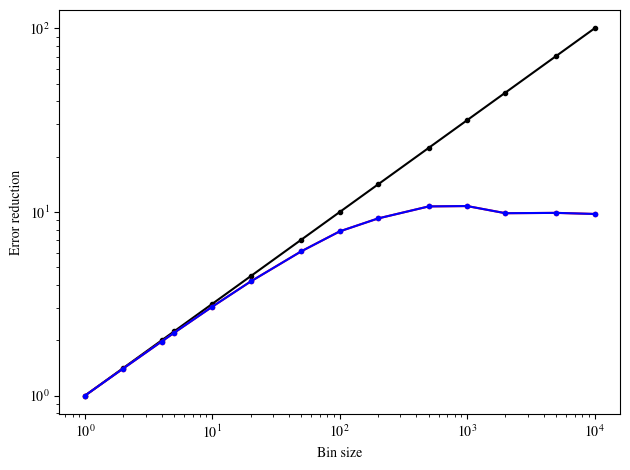

In [3]:
with open("scalar4d/config/c_8x8x8x8_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(8, 8,8,8), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [ ]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 8.053002602537163e-06 <O>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <O-f>: (np.float32(0.0011878875), np.complex128(6.720815102936334e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))


In [ ]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

In [ ]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

In [ ]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

In [ ]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

## m^2=0.01, lambda=0.1

jack bin size 1: (np.float32(0.012423942), np.complex128(5.52549667188217e-05+0j))
bin size 1: (np.float32(0.012423942), np.complex128(5.5258515064565094e-05+0j))
jack bin size 2: (np.float32(0.012423942), np.complex128(7.80913704445488e-05+0j))
bin size 2: (np.float32(0.012423942), np.complex128(7.809003801127697e-05+0j))
jack bin size 4: (np.float32(0.012423942), np.complex128(0.0001103191147122132+0j))
bin size 4: (np.float32(0.012423942), np.complex128(0.00011031821682325576+0j))
jack bin size 5: (np.float32(0.012423942), np.complex128(0.00012327366848688658+0j))
bin size 5: (np.float32(0.012423942), np.complex128(0.00012327759576363353+0j))
jack bin size 10: (np.float32(0.012423942), np.complex128(0.00017394727267881516+0j))
bin size 10: (np.float32(0.012423942), np.complex128(0.0001739468229305239+0j))
jack bin size 20: (np.float32(0.012423942), np.complex128(0.0002449656970134387+0j))
bin size 20: (np.float32(0.012423942), np.complex128(0.000244965412331678+0j))
jack bin size 50

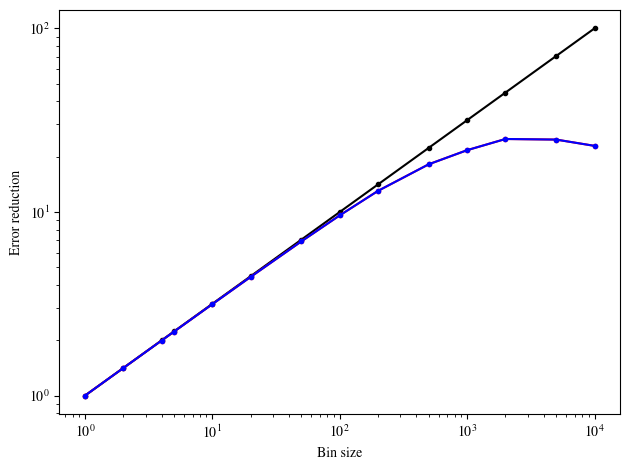

In [3]:
with open("scalar4d/config/c_8x8x8x8_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(8, 8,8,8), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [6]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [5]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00041522321407683194 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 8.145681204041466e-05 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012414069), np.complex128(0.0004310623596607395+0j)) <f>: (np.float32(-0.00047674534), np.complex128(0.0019324786459843602+0j))
Epoch 200: <Test loss>: 4.908275150228292e-05 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.0122484295), np.complex128(0.0002617455018642994+0j)) <f>: (np.float32(-0.00031112175), np.complex128(0.0017338620511172286+0j))
Epoch 300: <Test loss>: 7.020409975666553e-05 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012370835), np.complex128(0.0004868678547181042+0j)) <f>: (np.float32(-0.00043352653), np.com

In [7]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00041522321407683194 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 9.545249486109242e-05 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012356549), np.complex128(0.000360115030444717+0j)) <f>: (np.float32(-0.00041924615), np.complex128(0.00174822267735728+0j))
Epoch 400: <Test loss>: 9.10471280803904e-05 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012348781), np.complex128(0.0002985516156556659+0j)) <f>: (np.float32(-0.00041146972), np.complex128(0.0016243124197990945+0j))
Epoch 600: <Test loss>: 0.0001961984671652317 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012547771), np.complex128(0.0005837739187728573+0j)) <f>: (np.float32(-0.0006104602), np.complex12

In [8]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [9]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00041522321407683194 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.000484796823002398 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012780518), np.complex128(0.000793213186479902+0j)) <f>: (np.float32(-0.00084320724), np.complex128(0.0015193372568695648+0j))
Epoch 800: <Test loss>: 0.0003010065702255815 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012653469), np.complex128(0.0006314568431890126+0j)) <f>: (np.float32(-0.0007161572), np.complex128(0.0015867463155338094+0j))
Epoch 1200: <Test loss>: 0.00029810378327965736 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012756396), np.complex128(0.0006440959703294395+0j)) <f>: (np.float32(-0.0008190811), np.comple

In [10]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [11]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00041522321407683194 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.00026227813214063644 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012248121), np.complex128(0.0005221316600862073+0j)) <f>: (np.float32(-0.00031081357), np.complex128(0.001871278401537789+0j))
Epoch 1600: <Test loss>: 0.0012981041800230742 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012022921), np.complex128(0.001183970837467608+0j)) <f>: (np.float32(-8.560755e-05), np.complex128(0.0014623003254260502+0j))
Epoch 2400: <Test loss>: 0.000334713637130335 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012595547), np.complex128(0.0005310530405620195+0j)) <f>: (np.float32(-0.00065823423), np.compl

In [12]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [13]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00041522321407683194 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.00027298033819533885 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011450401), np.complex128(0.0008378528506233313+0j)) <f>: (np.float32(0.0004869105), np.complex128(0.0009494107495535954+0j))
Epoch 3200: <Test loss>: 0.00029624858871102333 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011532616), np.complex128(0.0009136340148388043+0j)) <f>: (np.float32(0.0004046984), np.complex128(0.0008323108160127051+0j))
Epoch 4800: <Test loss>: 0.001740394625812769 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011781999), np.complex128(0.0024120356479675887+0j)) <f>: (np.float32(0.00015530975), np.compl

### l4, w64

In [4]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [5]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00041522321407683194 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.00015854480443522334 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012944298), np.complex128(0.00037256424718336517+0j)) <f>: (np.float32(-0.0010069992), np.complex128(0.0016939183244403617+0j))
Epoch 200: <Test loss>: 6.779019895475358e-05 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012564314), np.complex128(0.0003612431071115288+0j)) <f>: (np.float32(-0.00062701124), np.complex128(0.0018241632419868045+0j))
Epoch 300: <Test loss>: 3.63264225597959e-05 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012604425), np.complex128(0.0003217950250169931+0j)) <f>: (np.float32(-0.00066711905), np.comp

In [6]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [7]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00041522321407683194 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.0002680255565792322 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012728359), np.complex128(0.0009364891671629611+0j)) <f>: (np.float32(-0.0007910537), np.complex128(0.0022718310271925223+0j))
Epoch 400: <Test loss>: 0.00016229529865086079 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012687367), np.complex128(0.0005523475530981453+0j)) <f>: (np.float32(-0.0007500501), np.complex128(0.0018303049469175431+0j))
Epoch 600: <Test loss>: 0.00014475877105724066 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.01257355), np.complex128(0.0005915079152252567+0j)) <f>: (np.float32(-0.0006362465), np.comple

In [8]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [9]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00041522321407683194 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.000427421648055315 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012392374), np.complex128(0.0007385085881938373+0j)) <f>: (np.float32(-0.00045506668), np.complex128(0.0020966184472769995+0j))
Epoch 800: <Test loss>: 0.00023249891819432378 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012988697), np.complex128(0.000622995491166407+0j)) <f>: (np.float32(-0.0010513731), np.complex128(0.0018529599765571268+0j))
Epoch 1200: <Test loss>: 0.0002312288706889376 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012920385), np.complex128(0.0005424925099105821+0j)) <f>: (np.float32(-0.000983075), np.complex

In [10]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [11]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00041522321407683194 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.0003643418021965772 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.0119368555), np.complex128(0.000688784983267987+0j)) <f>: (np.float32(4.5356154e-07), np.complex128(0.0012395623185985861+0j))
Epoch 1600: <Test loss>: 0.0002605509362183511 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011737254), np.complex128(0.0006883048156856673+0j)) <f>: (np.float32(0.0002000466), np.complex128(0.0010391929534801674+0j))
Epoch 2400: <Test loss>: 0.00027872141799889505 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011739339), np.complex128(0.0008346150495348886+0j)) <f>: (np.float32(0.00019798048), np.compl

In [12]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [13]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_8x8x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_2h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 2*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00041522321407683194 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.00046264618868008256 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012647253), np.complex128(0.0010122745812104045+0j)) <f>: (np.float32(-0.0007099529), np.complex128(0.0008445179826200279+0j))
Epoch 3200: <Test loss>: 0.00034455760032869875 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.011794178), np.complex128(0.001117345016492463+0j)) <f>: (np.float32(0.0001431243), np.complex128(0.0006686674204663319+0j))
Epoch 4800: <Test loss>: 0.00032699116854928434 <O>: (np.float32(0.011937312), np.complex128(0.0015528235224433302+0j)) <O-f>: (np.float32(0.012019442), np.complex128(0.0011986709428226628+0j)) <f>: (np.float32(-8.213878e-05), np.com

# 16x8x8x8

jack bin size 1: (np.float32(0.00025539257), np.complex128(4.718580965620353e-06+0j))
bin size 1: (np.float32(0.00025539257), np.complex128(4.718579426098136e-06+0j))
jack bin size 2: (np.float32(0.00025539257), np.complex128(6.6153928426799035e-06+0j))
bin size 2: (np.float32(0.00025539257), np.complex128(6.61536614929218e-06+0j))
jack bin size 4: (np.float32(0.00025539257), np.complex128(9.241323125324693e-06+0j))
bin size 4: (np.float32(0.00025539257), np.complex128(9.24131772201583e-06+0j))
jack bin size 5: (np.float32(0.00025539257), np.complex128(1.0277888827763741e-05+0j))
bin size 5: (np.float32(0.00025539257), np.complex128(1.0277895199333107e-05+0j))
jack bin size 10: (np.float32(0.00025539257), np.complex128(1.4172190280678994e-05+0j))
bin size 10: (np.float32(0.00025539257), np.complex128(1.4172204195933168e-05+0j))
jack bin size 20: (np.float32(0.00025539257), np.complex128(1.9192817965108578e-05+0j))
bin size 20: (np.float32(0.00025539257), np.complex128(1.919283324330952

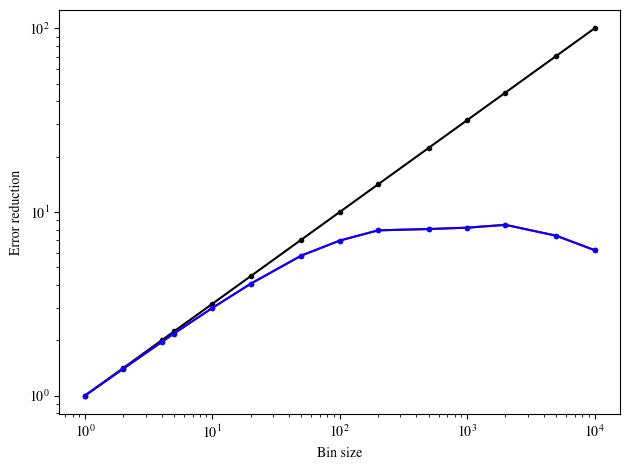

In [3]:
with open("scalar4d/config/c_16x8x8x8_0.1_0.5_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(16, 8,8,8), m2=0.1, lamda=0.5)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [6]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [5]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 2.9021271075180266e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 1.113855773837713e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00026664557), np.complex128(3.5562130093475796e-05+0j)) <f>: (np.float32(7.6985794e-05), np.complex128(4.784270541217432e-05+0j))
Epoch 200: <Test loss>: 1.1301762015136774e-07 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00027311046), np.complex128(1.2396322782858813e-05+0j)) <f>: (np.float32(7.052099e-05), np.complex128(5.619017620979877e-05+0j))
Epoch 300: <Test loss>: 1.2797177362244838e-07 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00027264748), np.complex128(1.3891941529282173e-05+0j)) <f>: (np.float32(7.0984

In [7]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 2.9021271075180266e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 9.162791911876411e-07 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.0002745814), np.complex128(3.146303236864255e-05+0j)) <f>: (np.float32(6.905005e-05), np.complex128(5.827745025974309e-05+0j))
Epoch 400: <Test loss>: 3.4819544225683785e-07 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00025316438), np.complex128(1.652574813322662e-05+0j)) <f>: (np.float32(9.046704e-05), np.complex128(6.403427185387741e-05+0j))
Epoch 600: <Test loss>: 2.959196194751712e-07 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00025882205), np.complex128(1.7144291949190474e-05+0j)) <f>: (np.float32(8.480946e-0

In [8]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [9]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 2.9021271075180266e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 4.894249741482781e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00036970762), np.complex128(6.0111363758015735e-05+0j)) <f>: (np.float32(-2.6076223e-05), np.complex128(6.962272953574675e-05+0j))
Epoch 800: <Test loss>: 2.331479208805831e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00024251493), np.complex128(3.698520932223576e-05+0j)) <f>: (np.float32(0.000101116704), np.complex128(7.501682083530123e-05+0j))
Epoch 1200: <Test loss>: 6.875184226373676e-07 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00024490184), np.complex128(2.1542955255186277e-05+0j)) <f>: (np.float32(9.872

In [10]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [11]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 2.9021271075180266e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.0005554841482080519 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(-6.883569e-05), np.complex128(0.0008414001282816733+0j)) <f>: (np.float32(0.00041246694), np.complex128(0.0008496690961197114+0j))
Epoch 1600: <Test loss>: 2.2908839127921965e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00030829353), np.complex128(3.8823971276198444e-05+0j)) <f>: (np.float32(3.5337944e-05), np.complex128(4.652173711817171e-05+0j))
Epoch 2400: <Test loss>: 1.1219034377063508e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00026185787), np.complex128(2.597157948013338e-05+0j)) <f>: (np.float32(8.177

In [12]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [13]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.1_0.5_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 2.9021271075180266e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 7.440384251822252e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00023667014), np.complex128(7.083141822054806e-05+0j)) <f>: (np.float32(0.00010696129), np.complex128(8.081232303627748e-05+0j))
Epoch 3200: <Test loss>: 2.9526001526392065e-05 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.00046663388), np.complex128(0.00019151222370720274+0j)) <f>: (np.float32(-0.00012300238), np.complex128(0.00020005904809667437+0j))
Epoch 4800: <Test loss>: 3.33036268784781e-06 <O>: (np.float32(0.00034363184), np.complex128(6.151087465555962e-05+0j)) <O-f>: (np.float32(0.000330618), np.complex128(5.7573528231306196e-05+0j)) <f>: (np.float32(1.301

## m^2=0.01, lamda=0.1

jack bin size 1: (np.float32(0.0047519677), np.complex128(2.4193233565428046e-05+0j))
bin size 1: (np.float32(0.0047519677), np.complex128(2.41939970034545e-05+0j))
jack bin size 2: (np.float32(0.0047519677), np.complex128(3.41776186845991e-05+0j))
bin size 2: (np.float32(0.0047519677), np.complex128(3.417888285517308e-05+0j))
jack bin size 4: (np.float32(0.0047519677), np.complex128(4.826344318113903e-05+0j))
bin size 4: (np.float32(0.0047519677), np.complex128(4.826205443166974e-05+0j))
jack bin size 5: (np.float32(0.0047519677), np.complex128(5.3917650825755836e-05+0j))
bin size 5: (np.float32(0.0047519677), np.complex128(5.391733841566924e-05+0j))
jack bin size 10: (np.float32(0.0047519677), np.complex128(7.599918748119268e-05+0j))
bin size 10: (np.float32(0.0047519677), np.complex128(7.599784546091029e-05+0j))
jack bin size 20: (np.float32(0.0047519677), np.complex128(0.00010681138619188218+0j))
bin size 20: (np.float32(0.0047519677), np.complex128(0.00010681086160132414+0j))
jack

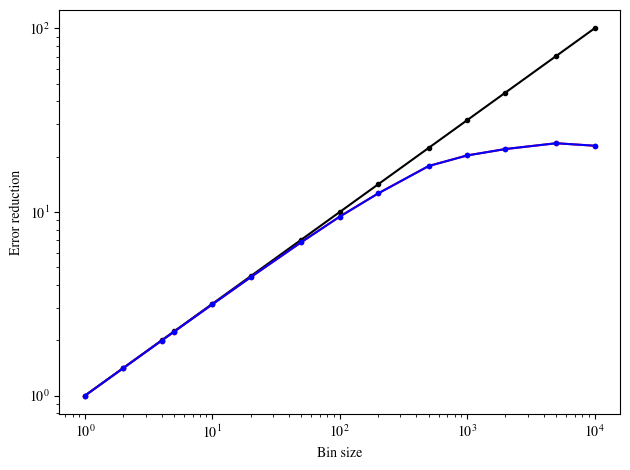

In [3]:
with open("scalar4d/config/c_16x8x8x8_0.01_0.1_sweep1.bin", "rb") as aa:
    m = np.fromfile(aa, dtype=np.int32, count=1)[0]
    n = np.fromfile(aa, dtype=np.int32, count=1)[0]
    data = np.fromfile(aa, dtype=np.float64, count=m * n).reshape((m, n), order='F').T

conf = jax.device_put(data)

# Correctly reshape Eigen column-major layout
# conf = data.reshape((m, n), order='F').T

model =  eval("scalar.Model(geom=(16, 8,8,8), m2=0.01, lamda=0.1)")
V=model.dof

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf)

error_jac, error_bi = [], []

for i in 1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000:
    jac, bi = jackknife(obs[:100000], Bs=i), bin(obs[:100000], Bs=i)
    print(f"jack bin size {i}: {jac}")
    print(f"bin size {i}: {bi}")
    error_jac.append(jac[1].real)
    error_bi.append(bi[1].real)

x_axis = np.array([1, 2, 4, 5, 10, 20, 50, 100,200, 500, 1000, 2000, 5000, 10000])

plt.plot(x_axis, np.sqrt(x_axis), color='black', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_jac)/error_jac[0], color='red', marker='.', linestyle='-')
plt.plot(x_axis, np.array(error_bi)/error_bi[0], color='blue', marker='.', linestyle='-')
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Bin size')
plt.ylabel('Error reduction')
plt.tight_layout()
#plt.legend()
plt.show()

In [4]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [5]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00014373238082043827 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.00011507108865771443 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0056659323), np.complex128(0.0006814493292748964+0j)) <f>: (np.float32(0.00048255312), np.complex128(0.0005808241548034785+0j))
Epoch 200: <Test loss>: 8.017936488613486e-05 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.005573864), np.complex128(0.000536499612529133+0j)) <f>: (np.float32(0.0005746172), np.complex128(0.0016187911903360246+0j))
Epoch 300: <Test loss>: 3.19901664624922e-05 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0055808565), np.complex128(0.0002464783928080086+0j)) <f>: (np.float32(0.0005676271), np.com

In [6]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [7]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00014373238082043827 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.001233301474712789 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.005054202), np.complex128(0.002534322469713107+0j)) <f>: (np.float32(0.0010942793), np.complex128(0.003609032410715252+0j))
Epoch 400: <Test loss>: 4.420544428285211e-05 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0054309326), np.complex128(0.0002861469904375423+0j)) <f>: (np.float32(0.00071755075), np.complex128(0.001382674966187263+0j))
Epoch 600: <Test loss>: 3.6237077438272536e-05 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.005475105), np.complex128(0.0002401321567849067+0j)) <f>: (np.float32(0.00067338144), np.compl

In [8]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [9]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00014373238082043827 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.00020119413966313004 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.006032812), np.complex128(0.0010421856597815449+0j)) <f>: (np.float32(0.00011566784), np.complex128(0.0004170622714045593+0j))
Epoch 800: <Test loss>: 4.0422142774332315e-05 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0056977225), np.complex128(0.00029346244187119185+0j)) <f>: (np.float32(0.0004507615), np.complex128(0.0009950472213002156+0j))
Epoch 1200: <Test loss>: 0.00011860570521093905 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0059059584), np.complex128(0.0007249872720527628+0j)) <f>: (np.float32(0.00024252509),

In [10]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [11]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00014373238082043827 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 7.342783646890894e-05 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0052997065), np.complex128(0.00034022549967191776+0j)) <f>: (np.float32(0.0008487739), np.complex128(0.001336756483202731+0j))
Epoch 1600: <Test loss>: 9.818605030886829e-05 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0058496925), np.complex128(0.0008027853304049625+0j)) <f>: (np.float32(0.000298792), np.complex128(0.0004040914353642987+0j))
Epoch 2400: <Test loss>: 9.904333273880184e-05 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.005809924), np.complex128(0.0007998352492839441+0j)) <f>: (np.float32(0.00033855895), np.c

In [12]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [32]*2)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [13]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.01_0.1_l2_w32_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_4h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 4*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00014373238082043827 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.0023390566930174828 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0074144914), np.complex128(0.0034502183466150475+0j)) <f>: (np.float32(-0.0012660049), np.complex128(0.002379677046763504+0j))
Epoch 3200: <Test loss>: 0.0002175052504753694 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.005889082), np.complex128(0.0014890285970030506+0j)) <f>: (np.float32(0.00025940477), np.complex128(0.0004387097102852065+0j))
Epoch 4800: <Test loss>: 0.00011925009312108159 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.005836177), np.complex128(0.0011380841965076894+0j)) <f>: (np.float32(0.0003123096), np

### l4, w64

In [4]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [5]:
binsize=1

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_5h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 5*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00014373238082043827 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 100: <Test loss>: 0.0002370414003962651 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.005340376), np.complex128(0.0005440681192560011+0j)) <f>: (np.float32(0.0008081084), np.complex128(0.0011995716534790618+0j))
Epoch 200: <Test loss>: 0.00011364262172719464 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.006075488), np.complex128(0.0005686079810895916+0j)) <f>: (np.float32(7.299608e-05), np.complex128(0.0006995340769275181+0j))
Epoch 300: <Test loss>: 9.65757280937396e-05 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.006347125), np.complex128(0.0008918491224375643+0j)) <f>: (np.float32(-0.00019864438), np.com

In [6]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [7]:
binsize=2

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_5h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 5*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00014373238082043827 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 200: <Test loss>: 0.0001555692870169878 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0059223846), np.complex128(0.000639427878776832+0j)) <f>: (np.float32(0.00022609964), np.complex128(0.0007648461289508787+0j))
Epoch 400: <Test loss>: 0.0001792251568986103 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.00584524), np.complex128(0.0006487966016402676+0j)) <f>: (np.float32(0.00030324268), np.complex128(0.0007068418215763259+0j))
Epoch 600: <Test loss>: 0.00011884656851179898 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0063731377), np.complex128(0.0008180169819079485+0j)) <f>: (np.float32(-0.00022465004), np.

In [8]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [9]:
binsize=4

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_5h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 5*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00014373238082043827 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 400: <Test loss>: 0.00023459522344637662 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.005910628), np.complex128(0.000444086540606777+0j)) <f>: (np.float32(0.00023785417), np.complex128(0.0011157261476634056+0j))
Epoch 1200: <Test loss>: 0.00012208976841066033 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0060053463), np.complex128(0.0008311335491265947+0j)) <f>: (np.float32(0.00014313818), np.complex128(0.00047867497155840063+0j))
Epoch 1600: <Test loss>: 0.00011536582314874977 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0061970167), np.complex128(0.0008635520919905598+0j)) <f>: (np.float32(-4.853165e-05)

In [10]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [11]:
binsize=8

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_5h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 5*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00014373238082043827 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 800: <Test loss>: 0.00010827824735315517 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.005905966), np.complex128(0.0007478097577580432+0j)) <f>: (np.float32(0.00024251641), np.complex128(0.0005044798878519362+0j))
Epoch 1600: <Test loss>: 0.00011269434617133811 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.005760219), np.complex128(0.0007158914264600192+0j)) <f>: (np.float32(0.00038826274), np.complex128(0.0005184203833150399+0j))
Epoch 2400: <Test loss>: 0.0001344707270618528 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.006231046), np.complex128(0.0011054534791968473+0j)) <f>: (np.float32(-8.256092e-05), n

In [12]:
key = jax.random.PRNGKey(1)
g1 = CV_MLP(V, [64]*4)
g_params = g1.init(key, jnp.zeros(V))

index = jnp.array([
    tuple(-x for x in coords)
    for coords in product(*(range(dim) for dim in model.shape))
])


def g(x, p):
    def g_(x, p, ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        return g1.apply(p, rolled_x)[0]
    return jnp.ravel(jax.vmap(lambda ind: g_(x, p, ind))(index).T)


dS = jax.grad(lambda y: model.action(y).real)


@jax.jit
def f(x, p):
    # diagonal sum (Stein's identity)
    def diag_(ind):
        rolled_x = jnp.roll(x.reshape(model.shape), shift=ind, axis=tuple(
            range(len(model.shape)))).reshape(-1)

        ei = jnp.zeros_like(x).at[0].set(1.0)
        _, jvp_val = jax.jvp(lambda y: g1.apply(p, y)[0], (rolled_x,), (ei,))

        return jvp_val[0]
    j = jax.vmap(diag_)(index).sum()
    return j - g(x, p)@dS(x)


@jax.jit
def Loss(x, p):
    _, y = g1.apply(p, x)
    al = 0

    # shift is not regularized
    return jnp.abs(model.observe(x, model.shape[0]//2) - f(x, p) - y[0])**2 + al * l2_regularization(p)


def Loss_batch(batch, params):
    # Compute the per-sample losses
    per_sample_losses = jax.vmap(Loss, in_axes=(0, None))(batch, params)
    # Return the average loss over the batch
    return jnp.mean(per_sample_losses)


Loss_batch_grad = jax.jit(jax.grad(Loss_batch, argnums=1))

In [ ]:
binsize=16

sched = optax.constant_schedule(1e-4)

opt = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    # optax.adamw(1e-3)
    optax.scale_by_adam(),  # Use the updates from adam.
    # Use the learning rate from the scheduler.
    optax.scale_by_schedule(sched),
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = opt.init(g_params)

@jax.jit
def train_batch_shard(x, p, opt_state):
    grad = Loss_batch_grad(x, p)
    updates, opt_state = opt.update(grad, opt_state)
    p = optax.apply_updates(p, updates)
    return p, opt_state


n_train = 10000 // binsize
n_test = 1000
nt = 32
ns = 50

conf_train = conf[:n_train*binsize:binsize]
conf_test = conf[-n_test*100::100]

obs = jax.vmap(lambda x: model.observe(x, model.shape[0]//2))(conf_test)
obs_av = jackknife(np.array(obs))

track_red, track_ltest = [], []

f_vmap = jax.vmap(f, in_axes=(0, None))
Loss_vmap = jax.vmap(Loss, in_axes=(0, None))


def save():
    with open("correlated/scalar4d/cv_16x8x8x8_0.01_0.1_l4_w64_lr1e-4_nt32_ridge0_test1e3_train1e4_sweep1_bs"+str(binsize)+"_5h.pkl", "wb") as aa:
        pickle.dump((g1, g_params, opt_state, track_red, track_ltest), aa)


from jax.sharding import PartitionSpec as P, NamedSharding, Mesh

mesh = jax.make_mesh((num_devices,), ('batch',))

sharding = NamedSharding(mesh, P('batch'))
replicated_sharding = NamedSharding(mesh, P())

g_params = jax.device_put(g_params, replicated_sharding)


start_time = time.time()
epochs = 0
# Training
while time.time() - start_time < 5*3600:
    key, _ = jax.random.split(key)
    conf_train = jax.random.permutation(key, conf_train)

    if epochs % (100*binsize) == 0:
        # Reduce memory usage
        fs, ls = [], []
        for i in range(n_test//ns):
            fs.append(jax.vmap(lambda x: f(x, g_params))(conf_test[ns*i: ns*(i+1)]))
            ls.append(jax.vmap(lambda x: Loss(x, g_params))(conf_test[ns*i: ns*(i+1)]))
        fs = jnp.ravel(jnp.array(fs))
        ls = jnp.mean(jnp.array(ls))

        print(
            f"Epoch {epochs}: <Test loss>: {ls} <O>: {obs_av} <O-f>: {jackknife(np.array(obs-fs))} <f>: {jackknife(np.array(fs))}", flush=True)

        track_red.append([epochs, jackknife(obs)[1]/jackknife(obs-fs)[1]])
        track_ltest.append([epochs, ls])

        save()

    for s in range(n_train//nt):  # one epoch
        g_params, opt_state = train_batch_shard(
            conf_train[nt*s: nt*(s+1)], g_params, opt_state)

    epochs+=1

Epoch 0: <Test loss>: 0.00014373238082043827 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <f>: (np.float32(0.0), np.complex128(0j))
Epoch 1600: <Test loss>: 0.0001844009238993749 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.006285848), np.complex128(0.001234804536562306+0j)) <f>: (np.float32(-0.00013736695), np.complex128(0.0002458095834304684+0j))
Epoch 3200: <Test loss>: 0.00010333464160794392 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.0060601113), np.complex128(0.0009632976146744467+0j)) <f>: (np.float32(8.8372566e-05), np.complex128(0.00032009306245836647+0j))
Epoch 4800: <Test loss>: 0.00010633793863235041 <O>: (np.float32(0.0061484845), np.complex128(0.0011717687452865184+0j)) <O-f>: (np.float32(0.006075277), np.complex128(0.001082033226081292+0j)) <f>: (np.float32(7.320944e-05), 